In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Dropout, LSTM, Bidirectional, SpatialDropout1D, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('stopwords')

# def remove_english_stopwords(text):
#    stop_words = set(stopwords.words('english'))
#    word_tokens = word_tokenize(text)
#    filtered_text = [word for word in word_tokens if not word in stop_words]
#    return ' '.join(filtered_text)

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text



In [3]:
def preprocess(text):
    text = remove_nonaplhanumeric(text) 
    text = remove_unnecessary_char(text) 
#     text = remove_english_stopwords(text) 
    return text

Train data contain text and labels with answers.

In [4]:
train_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv',index_col='id')
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train_data['comment_text'] = train_data['comment_text'].apply(preprocess)
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0
000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0
0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0
0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0


We need to found which length of message we will analyse for prediction

In [6]:
train_data['comment_length'] = train_data['comment_text'].apply(lambda row: len(row))
train_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,261
000103f0d9cfb60f,D aww He matches this background colour I m se...,0,0,0,0,0,0,103
000113f07ec002fd,Hey man I m really not trying to edit war It s...,0,0,0,0,0,0,230
0001b41b1c6bb37e,More I can t make any real suggestions on imp...,0,0,0,0,0,0,603
0001d958c54c6e35,You sir are my hero Any chance you remember wh...,0,0,0,0,0,0,64


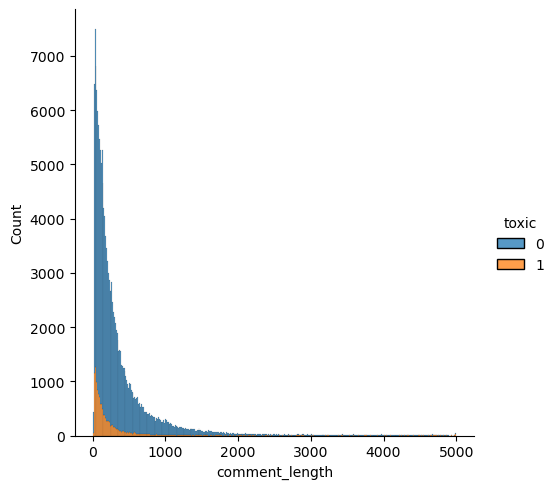

In [7]:
import seaborn as sns
sns.displot(
    data=train_data, 
    x="comment_length", 
    hue='toxic',
    multiple="stack",
)

In [8]:
toxic_data = train_data[train_data['toxic'] == 1]
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length
id,,,,,,,,
0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
0005c987bdfc9d4b,Hey what is it talk What is it an exclusive gr...,1,0,0,0,0,0,296
0007e25b2121310b,Bye Don t look come or think of comming back T...,1,0,0,0,0,0,52
001810bf8c45bf5f,You are gay or antisemmitian Archangel WHite T...,1,0,1,0,1,1,615
00190820581d90ce,FUCK YOUR FILTHY MOTHER IN THE ASS DRY,1,0,1,0,1,0,39


Length of toxic comments: max 5000, min 4, mean 209.4926114816268, median 84.0.

In [9]:
print(
    'max', toxic_data['comment_length'].max(),
    'min', toxic_data['comment_length'].min(),
    'mean', toxic_data['comment_length'].mean(),
    'median', toxic_data['comment_length'].median(),
    '75%', toxic_data['comment_length'].quantile(0.75),
)

max 5000 min 8 mean 280.898260755852 median 118.0 75% 260.0


 So 300 symbols should be enough.

In [10]:
max_comment_len = 300

Test data contain two files with text and labels separately.

In [11]:
test_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv',index_col='id')
test_data.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [12]:
test_labels_data = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv',index_col='id')
test_labels_data.head()


,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,-1,-1,-1,-1,-1,-1
0000247867823ef7,-1,-1,-1,-1,-1,-1
00013b17ad220c46,-1,-1,-1,-1,-1,-1
00017563c3f7919a,-1,-1,-1,-1,-1,-1
00017695ad8997eb,-1,-1,-1,-1,-1,-1


And some labels has value of -1, that indicates it was not used for scoring; (Note: file added after competition close!)

In [13]:
test_data = test_data.join(test_labels_data)
test_data = test_data[test_data['toxic'] != -1]
test_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


Solution from "Toxic Comment Classification Challenge" on base of RNN, that taken [3rd place](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52644)

Neural networks this is a series of algorithms that seek to identify relationships in a data without being explicitly programmed. 

Neural networks works with numbers, so we need convert messages to numbers.

TextVectorization - A preprocessing layer which maps text features to integer sequences.

max_tokens - Maximum size of the vocabulary for this layer.

adapt - Computes a vocabulary of string terms from tokens in a dataset.

encoder - this is vocabulary created on base of training messages, this is first layer of network that convert coming messages into list of numbers.

Embeding - turns positive integers (indexes) into dense vectors of fixed size. Dense vectors this is modern kind of representing words as vector, this solution have famose effect: King - Man + Woman = Queen.

SpatialDropout1D - dropout, however, it drops entire 1D feature maps instead of individual elements. Dropout removes some neurons from network, this solution help to avoid overfitting.

LSTM - Long Short-Term Memory layer, this is kind of Recurrent Neural Network. return_sequences - whether to return the last output in the output sequence, or the full sequence.

Dense - densely-connected NN layer. Final layer that contain 6 neurons with result.

In [14]:
num_words = 10000
encoder = TextVectorization(max_tokens=num_words)
encoder.adapt(train_data['comment_text'].values)

model_bidirectional = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True,
        input_length=max_comment_len,
    ),
    SpatialDropout1D(0.5),
    Bidirectional(LSTM(40, return_sequences=True)),
    Bidirectional(LSTM(40)),
    Dense(6, activation='sigmoid'),
])

Training of neural network this is a process which reduce difference between correct result and result of neural network. NN reduce error by [gradient descent](https://developers.google.com/machine-learning/crash-course/reducing-loss/gradient-descent). 

Loss function - a mesure for difference between real and prediction values. There are different [loss functions](https://kitchell.github.io/DeepLearningTutorial/7lossfunctionsoptimizers.html): 
binary crossentropy, 
categorical crossentropy, 
mean squared error.

Gradient descent have [different optimizations](https://www.geeksforgeeks.org/optimization-techniques-for-gradient-descent/):
SGD,
Adam,
Momentum, 
AdaGrad.


In [15]:
model_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/) callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [16]:
model_bidir_save_path = '/kaggle/working/toxic_model_bidir'
checkpoint_callback_lstm = ModelCheckpoint(
    model_bidir_save_path, 
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_format='tf',
)

In [17]:
!rm -r /kaggle/working/toxic_model_lstm

rm: cannot remove '/kaggle/working/toxic_model_lstm': No such file or directory


In [18]:
x_train1 = train_data['comment_text'].values
y_train1 = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

In [19]:
from sklearn.model_selection import train_test_split 
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,train_size=0.8,shuffle=True,random_state=42)

In [20]:
x_train[:2]

array(['Grandma Terri Should Burn in Trash Grandma Terri is trash I hate Grandma Terri F K her to HELL 71 74 76 40',
       ' 9 May 2009 UTC It would be easiest if you were to admit to being a member of the involved Portuguese Lodge and then there would be no requirement to acknowledge whether you had a previous account Carlos Botelho did not have a good record or not and I would then remove the sockpuppet template as irrelevant WP COI permits people to edit those articles such as MSJapan does but just means you have to be more careful in ensuring that references back your edits and that NPOV is upheld 20 29'],
      dtype=object)

In [21]:
y_train[:2]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [22]:
history_bidir = model_bidirectional.fit(
    x_train, 
    y_train, 
    validation_data=(x_val,y_val),
    epochs=5, # 15
    batch_size=512,
    callbacks=[checkpoint_callback_lstm],
)

Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.8065 - auc: 0.8491
Epoch 1: val_accuracy improved from -inf to 0.97522, saving model to /kaggle/working/toxic_model_bidir
250/250 [==============================] - 167s 589ms/step - loss: 0.1408 - accuracy: 0.8065 - auc: 0.8491 - val_loss: 0.0627 - val_accuracy: 0.9752 - val_auc: 0.9708
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9928 - auc: 0.9770
Epoch 2: val_accuracy improved from 0.97522 to 0.99389, saving model to /kaggle/working/toxic_model_bidir
250/250 [==============================] - 132s 528ms/step - loss: 0.0534 - accuracy: 0.9928 - auc: 0.9770 - val_loss: 0.0511 - val_accuracy: 0.9939 - val_auc: 0.9825
Epoch 3/5
250/250 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9933 - auc: 0.9807
Epoch 3: val_accuracy did not improve from 0.99389
250/250 [==============================] - 76s 303ms/step - loss: 0.0482 - accu

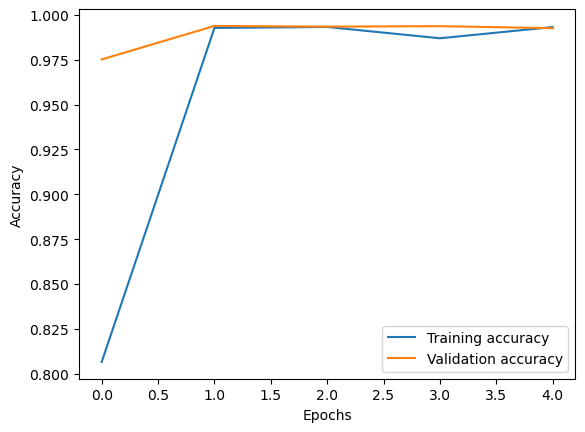

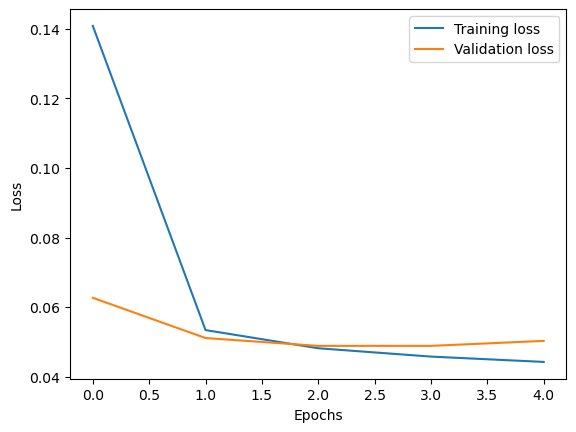

In [23]:
plt.plot(history_bidir.history['accuracy'], 
         label='Training accuracy')
plt.plot(history_bidir.history['val_accuracy'], 
         label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.plot(history_bidir.history['loss'], 
         label='Training loss')
plt.plot(history_bidir.history['val_loss'], 
         label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Get data for testing

In [24]:
x_test = test_data['comment_text'].values
y_test = test_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

Check result

In [25]:
model_bidirectional.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0770 - accuracy: 0.9930 - auc: 0.9660


[0.077007956802845, 0.9929975867271423, 0.9660161733627319]

Check result of saved model

In [26]:
saved_model = load_model(model_bidir_save_path)
saved_model.evaluate(x_test, y_test, verbose=1)

2000/2000 [==============================] - 53s 24ms/step - loss: 0.0853 - accuracy: 0.9946 - auc: 0.9689


[0.08531610667705536, 0.9946075081825256, 0.9689204096794128]

In [27]:
!zip -r /kaggle/working/toxic_model_bidir.zip /kaggle/working/toxic_model_bidir

  adding: kaggle/working/toxic_model_bidir/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/fingerprint.pb (stored 0%)
  adding: kaggle/working/toxic_model_bidir/variables/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/variables/variables.index (deflated 65%)
  adding: kaggle/working/toxic_model_bidir/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/toxic_model_bidir/keras_metadata.pb (deflated 91%)
  adding: kaggle/working/toxic_model_bidir/assets/ (stored 0%)
  adding: kaggle/working/toxic_model_bidir/saved_model.pb (deflated 90%)


In [28]:
test_data[test_data['toxic']==1][:5]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
00091c35fa9d0465,"== Arabs are committing genocide in Iraq, but ...",1,0,0,0,0,0
0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...,1,0,1,0,1,1
0017d4d47894af05,":Fuck off, you anti-semitic cunt. |",1,0,1,0,1,0
001d739c97bc2ae4,How dare you vandalize that page about the HMS...,1,0,0,0,0,0
001eff4007dbb65b,"::No, he is an arrogant, self serving, immatur...",1,0,1,0,1,0


In [29]:
test_data[test_data['toxic']==1][:5]['comment_text'].values

array(['== Arabs are committing genocide in Iraq, but no protests in Europe. == \n\n May Europe also burn in hell.',
       'DJ Robinson is gay as hell! he sucks his dick so much!!!!!',
       ':Fuck off, you anti-semitic cunt.  |',
       "How dare you vandalize that page about the HMS Beagle! Don't vandalize again, demon!",
       '::No, he is an arrogant, self serving, immature idiot. Get it right.'],
      dtype=object)

In [30]:
test_labels = saved_model.predict(test_data[test_data['toxic']==1][:5]['comment_text'].values)
for labels in test_labels:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 5s 5s/step
[0.73, 0.0, 0.21, 0.0, 0.26, 0.03]
[0.98, 0.21, 0.91, 0.06, 0.8, 0.14]
[0.96, 0.42, 0.89, 0.14, 0.86, 0.25]
[0.31, 0.0, 0.05, 0.0, 0.06, 0.01]
[0.98, 0.15, 0.88, 0.05, 0.76, 0.12]


In [31]:
quotes = [
    "It takes a great deal of bravery to stand up to your enemies, but a great deal more to stand up to your friends.",
    "No, no. This kind of mark cannot be seen. It lives in your very skin… Love, Harry. Love.",
    "I would trust Hagrid with my own life.",
    "Also, our caretaker, Mr. Filch, has asked me to remind you that the third-floor corridor on the right-hand side is out of bounds to everyone who does not wish to die a most painful death.",
    "It is not our abilities that show what we truly are. It is our choices.",
]
not_toxic_prediction = saved_model.predict(quotes)
for labels in not_toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 40ms/step
[0.08, 0.0, 0.01, 0.0, 0.01, 0.0]
[0.02, 0.0, 0.01, 0.0, 0.01, 0.0]
[0.17, 0.0, 0.02, 0.0, 0.03, 0.01]
[0.62, 0.0, 0.12, 0.0, 0.18, 0.02]
[0.03, 0.0, 0.01, 0.0, 0.01, 0.0]


In [32]:
quotes = [
    "Maybe If The Fat Lump Had Given This A Squeeze, He'd Have Remembered To Fall On His Fat Ass.",
    "No One Asked Your Opinion, You Filthy Little Mudblood.",
    "Didn't Mummy Ever Tell You It Was Rude To Eavesdrop, Potter? Oh, Yeah. She Was Dead Before You Could Wipe The Drool Off Your Chin.",
    "You're Gonna Regret This! You And Your Bloody Chicken!",
    "I'm going to kill you, Harry Potter. I'm going to destroy you.",
]
toxic_prediction = saved_model.predict(quotes)
for labels in toxic_prediction:
    print([ round(lbl, 2) for lbl in labels])

1/1 [==============================] - 0s 40ms/step
[0.96, 0.04, 0.75, 0.02, 0.63, 0.09]
[0.83, 0.01, 0.38, 0.0, 0.32, 0.03]
[0.87, 0.01, 0.46, 0.01, 0.39, 0.04]
[0.97, 0.21, 0.87, 0.07, 0.8, 0.15]
[0.95, 0.07, 0.76, 0.02, 0.66, 0.08]


In [33]:

predicts= saved_model.predict(x_test ,verbose=1)

2000/2000 [==============================] - 46s 23ms/step


In [34]:
for i in predicts[:5]:
     print([ round(lbl, 2) for lbl in i])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.46, 0.01, 0.1, 0.01, 0.11, 0.02]
[0.15, 0.0, 0.04, 0.0, 0.03, 0.01]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts_val = saved_model.predict(x_val, verbose=1)

for threshold in thresholds:
  y_pred_val = (predicts_val > threshold)
  clr = classification_report(y_val, y_pred_val)
  accuracy = accuracy_score(y_val, y_pred_val)
  f1 = f1_score(y_val, y_pred_val, average='weighted')
  precision = precision_score(y_val, y_pred_val, average='weighted')
  recall = recall_score(y_val, y_pred_val, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")


998/998 [==============================] - 21s 21ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.49      0.94      0.64      3056
           1       0.28      0.84      0.42       321
           2       0.54      0.95      0.69      1715
           3       0.03      0.09      0.05        74
           4       0.47      0.94      0.62      1614
           5       0.14      0.50      0.22       294

   micro avg       0.45      0.91      0.60      7074
   macro avg       0.33      0.71      0.44      7074
weighted avg       0.47      0.91      0.62      7074
 samples avg       0.06      0.09      0.07      7074

F1 Score: 0.6166542816582777
Precision: 0.4685064198059837
Recall: 0.910941475826972

Accuracy: 0.8292965690114367

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.64      0.89      0.74      3056
           1       0.36      0.67      0.47       321
  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1

Threshold: 0.4
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3056
           1       0.57      0.26      0.35       321
           2       0.76      0.83      0.79      1715
           3       0.00      0.00      0.00        74
           4       0.69      0.75      0.72      1614
           5       0.00      0.00      0.00       294

   micro avg       0.74      0.74      0.74      7074
   macro avg       0.46      0.44      0.44      7074
weighted avg       0.70      0.74      0.71      7074
 samples avg       0.07      0.07      0.07      7074

F1 Score: 0.7143623623914468
Precision: 0.6977432014306756
Recall: 0.738620299689002

Accuracy: 0.9122669591101363

Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3056
           1       0.57      0.01      0.02       321
  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: 

Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      3056
           1       0.00      0.00      0.00       321
           2       0.87      0.64      0.74      1715
           3       0.00      0.00      0.00        74
           4       0.81      0.49      0.61      1614
           5       0.00      0.00      0.00       294

   micro avg       0.88      0.56      0.69      7074
   macro avg       0.43      0.30      0.36      7074
weighted avg       0.79      0.56      0.66      7074
 samples avg       0.06      0.05      0.05      7074

F1 Score: 0.6559543830338179
Precision: 0.7900597478441114
Recall: 0.5623409669211196

Accuracy: 0.9180636064546451

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      3056
           1       0.00      0.00      0.00       321
 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predicts = saved_model.predict(x_test, verbose=1)

for threshold in thresholds:
  y_pred = (predicts > threshold)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  print(f"Threshold: {threshold}\nClassification Report:\n----------------------\n{clr}\nF1 Score: {f1}\nPrecision: {precision}\nRecall: {recall}\n\nAccuracy: {accuracy}\n")

2000/2000 [==============================] - 46s 23ms/step
Threshold: 0.1
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3056
           1       0.00      0.00      0.00       321
           2       0.95      0.22      0.36      1715
           3       0.00      0.00      0.00        74
           4       0.71      0.00      0.01      1614
           5       0.00      0.00      0.00       294

   micro avg       0.97      0.27      0.42      7074
   macro avg       0.44      0.12      0.17      7074
weighted avg       0.81      0.27      0.37      7074
 samples avg       0.05      0.02      0.03      7074

F1 Score: 0.4258373164424744
Precision: 0.278113936571612
Recall: 0.9184025382811423

Accuracy: 0.7098064959829942

Threshold: 0.2
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      30

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.5
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3056
           1       0.00      0.00      0.00       321
           2       0.95      0.22      0.36      1715
           3       0.00      0.00      0.00        74
           4       0.71      0.00      0.01      1614
           5       0.00      0.00      0.00       294

   micro avg       0.97      0.27      0.42      7074
   macro avg       0.44      0.12      0.17      7074
weighted avg       0.81      0.27      0.37      7074
 samples avg       0.05      0.02      0.03      7074

F1 Score: 0.5866362377457762
Precision: 0.5055350139468714
Recall: 0.7095461442957649

Accuracy: 0.8608271593360217

Threshold: 0.6
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3056
           1       0.00      0.00      0.00       321
 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.7
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3056
           1       0.00      0.00      0.00       321
           2       0.95      0.22      0.36      1715
           3       0.00      0.00      0.00        74
           4       0.71      0.00      0.01      1614
           5       0.00      0.00      0.00       294

   micro avg       0.97      0.27      0.42      7074
   macro avg       0.44      0.12      0.17      7074
weighted avg       0.81      0.27      0.37      7074
 samples avg       0.05      0.02      0.03      7074

F1 Score: 0.5994997469027578
Precision: 0.6278543537103374
Recall: 0.592357566560905

Accuracy: 0.8893525899527963

Threshold: 0.8
Classification Report:
----------------------
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      3056
           1       0.00      0.00      0.00       321
  

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
